# Machine learning for Time Series Data

The dataset we are going to use comes from:
- Heartbeat wave: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds/
- Stock prices

In [8]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from glob import glob
import librosa as lr 

audio, sfreq = lr.load('../data/murmur__201101051104.wav')

In [4]:
print(sfreq)

22050


Knowing the sampling rate of a timeseries we can know the timestamp of each datapoint relative to the first datapoint.

(assuming the sampling rate is fixed and no datapoints are lost)

In [5]:
audio

array([-0.05220414, -0.05821276, -0.0463625 , ..., -0.04417123,
       -0.05130248, -0.02166671], dtype=float32)

In [6]:
len(audio)

195894

In [9]:
indices = np.arange(0, len(audio))
time = indices/sfreq

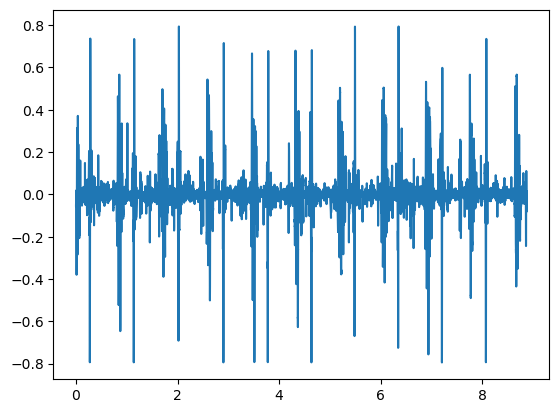

In [22]:
plt.plot(time, audio)

In [12]:
prices = pd.read_csv('../data/prices.csv', parse_dates=['date'], index_col='date')
prices

,symbol,close,volume
date,,,
2010-01-04,AAPL,214.009998,123432400.0
2010-01-04,ABT,54.459951,10829000.0
2010-01-04,AIG,29.889999,7750900.0
2010-01-04,AMAT,14.300000,18615100.0
2010-01-04,ARNC,16.650013,11512100.0
...,...,...,...
2016-12-30,VZ,53.380001,12440800.0
2016-12-30,WFC,55.110001,15095500.0
2016-12-30,XOM,90.260002,9117800.0


In [20]:
pivot_prices = prices.pivot(values='close', columns='symbol')
pivot_prices = pivot_prices[['AAPL', 'FB', 'NFLX', 'V']]

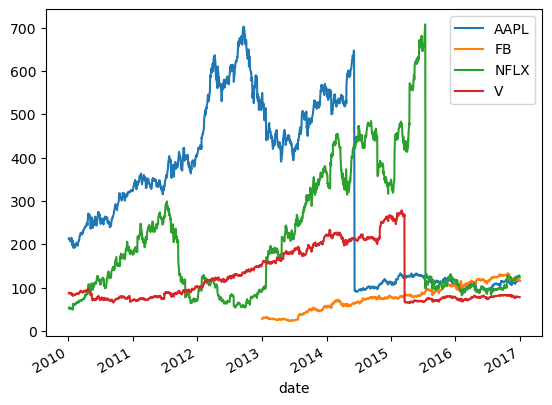

In [21]:
# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in pivot_prices.columns:
    pivot_prices[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

In [ ]:
# Classification